# Initial Comparison

We run integrated gradients and activation patching on the same model and dataset, to compare attribution scores.

- Model: GPT2-Small (12 layers, 12 attention heads per layer, embedding size 768, 3,072 neurons per MLP layer)
- Dataset: Indirect Object Identification task

In [26]:
%load_ext autoreload
%autoreload 2

In [27]:
import torch
from transformer_lens import HookedTransformer
from transformer_lens.utils import get_device

from attribution_methods import activation_patching, highlight_components
from testing import Task, TaskDataset, logit_diff_metric, average_correlation, measure_overlap
from plotting import plot_attn_comparison, plot_correlation_comparison, plot_mean_diff

In [9]:
torch.cuda.empty_cache()

device = get_device()
model = HookedTransformer.from_pretrained("gpt2-small", device=device)

# Explicitly calculate and expose the result for each attention head
model.set_use_attn_result(True)
model.set_use_hook_mlp_in(True)

Loaded pretrained model gpt2-small into HookedTransformer


## Experiment

In [3]:
ioi_dataset = TaskDataset(Task.IOI)
ioi_dataloader = ioi_dataset.to_dataloader(batch_size=100)

clean_input, corrupted_input, labels = next(iter(ioi_dataloader))

clean_tokens = model.to_tokens(clean_input)
corrupted_tokens = model.to_tokens(corrupted_input)

clean_logits, clean_cache = model.run_with_cache(clean_tokens)
clean_logit_diff = logit_diff_metric(clean_logits, labels)
print(f"Clean logit difference: {clean_logit_diff}")

corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_tokens)
corrupted_logit_diff = logit_diff_metric(corrupted_logits, labels)
print(f"Corrupted logit difference: {corrupted_logit_diff}")

Clean logit difference: tensor([-0.0307, -0.9269, -0.4937,  2.2320,  0.6754,  4.0447, -0.1785,  1.1947,
         1.1514,  1.7507,  0.1791,  4.2971,  2.9955, -0.7016, -2.1907, -3.5684,
        -4.4879, -1.2934, -3.8906, -0.6969, -0.8222,  0.0708,  0.2167,  4.4769,
         1.0375, -1.2644,  0.9309,  2.8114,  0.9975,  2.4103,  2.6244,  0.0125,
        -0.8472, -0.6130, -1.1623, -0.5109,  3.0073,  0.6154, -1.1229,  0.2680,
        -2.7379,  5.2855,  2.5019,  0.3219, -1.3112,  1.2942, -2.1428,  3.1053,
         1.6090,  3.1023,  1.8912,  0.4089,  4.0511,  2.5005,  3.5176, -1.5472,
         2.2213, -0.8523,  0.6682,  0.4244,  0.8053,  3.2905,  0.7295,  0.9946,
        -3.6073, -2.2671,  1.7894, -0.6390,  0.6320, -1.5326,  1.3206, -0.1224,
         0.1692,  1.9326,  3.1771,  1.1320, -0.0876,  3.1172,  2.3856,  3.2836,
        -2.0859,  3.6953,  2.8493, -2.4261,  1.1299,  0.1732, -1.4748, -2.1046,
        -0.6516, -0.6167,  0.0277, -1.7128,  0.6374,  2.6353, -1.4080,  3.2583,
         0.6919,

In [12]:
from transformer_lens.utils import get_act_name
from attribution_methods import compute_layer_to_output_attributions

torch.set_grad_enabled(True)

# Standard integrated gradients with zero baseline

n_samples = clean_tokens.size(0)

ig_mlp_results = torch.zeros(n_samples, model.cfg.n_layers, model.cfg.d_mlp)
ig_attn_results = torch.zeros(n_samples, model.cfg.n_layers, model.cfg.n_heads)

# Calculate integrated gradients for each layer
for layer in range(model.cfg.n_layers):

    # Gradient attribution on heads
    hook_name = get_act_name("result", layer)
    target_layer = model.hook_dict[hook_name]
    prev_layer_hook = get_act_name("z", layer)
    prev_layer = model.hook_dict[prev_layer_hook]

    layer_input = clean_cache[prev_layer_hook]
    # Use zero activations as the baseline
    layer_baseline = torch.zeros_like(layer_input)

    # Shape [batch, seq_len, d_head, d_model]
    attributions = compute_layer_to_output_attributions(
        model,
        clean_tokens,
        layer_input,
        layer_baseline,
        target_layer,
        prev_layer,
        logit_diff_metric,
        labels,
    )

    # Calculate score based on mean over each embedding, for each token
    per_token_score = attributions.mean(dim=3)
    score = per_token_score.mean(dim=1)
    ig_attn_results[:, layer] = score

    # Gradient attribution on MLP neurons
    hook_name = get_act_name("post", layer)
    target_layer = model.hook_dict[hook_name]
    prev_layer_hook = get_act_name("mlp_in", layer)
    prev_layer = model.hook_dict[prev_layer_hook]

    layer_input = clean_cache[prev_layer_hook]
    layer_baseline = torch.zeros_like(layer_input)

    # Shape [batch, seq_len, d_model]
    attributions = compute_layer_to_output_attributions(
        model,
        clean_tokens,
        layer_input,
        layer_baseline,
        target_layer,
        prev_layer,
        logit_diff_metric,
        labels,
    )
    score = attributions.mean(dim=1)
    ig_mlp_results[:, layer] = score


Error (delta) for blocks.0.attn.hook_result attribution: tensor([-8.8226], device='mps:0')

Error (delta) for blocks.0.mlp.hook_post attribution: tensor([0.4419], device='mps:0')

Error (delta) for blocks.1.attn.hook_result attribution: tensor([-8.6427e-06], device='mps:0')

Error (delta) for blocks.1.mlp.hook_post attribution: tensor([-3.7789e-05], device='mps:0')

Error (delta) for blocks.2.attn.hook_result attribution: tensor([-1.0908e-05], device='mps:0')

Error (delta) for blocks.2.mlp.hook_post attribution: tensor([2.5511e-05], device='mps:0')

Error (delta) for blocks.3.attn.hook_result attribution: tensor([-4.4703e-06], device='mps:0')

Error (delta) for blocks.3.mlp.hook_post attribution: tensor([2.3842e-07], device='mps:0')

Error (delta) for blocks.4.attn.hook_result attribution: tensor([-1.3024e-05], device='mps:0')

Error (delta) for blocks.4.mlp.hook_post attribution: tensor([-8.5831e-06], device='mps:0')

Error (delta) for blocks.5.attn.hook_result attribution: tensor([

In [7]:
torch.save(ig_mlp_results, "results/initial/ig_mlp_zero_results.pt")
torch.save(ig_attn_results, "results/initial/ig_attn_zero_results.pt")

In [ ]:
# Activation patching
ap_mlp_results, ap_attn_results = activation_patching(model, clean_tokens, clean_logit_diff, corrupted_cache, corrupted_logit_diff, logit_diff_metric, labels)

## Analysis

To evaluate the similarity between standard integrated gradients and activation patching, we:

- Visualise the attention heads highlighted by each method for the sample
- Plot the correlation between the attribution scores
- Measure the amount of overlap between highlighted components
- Visualise the mean-difference plot

### Specific example

In [11]:
clean_input = "When John and Mary went to the store, John gave a bottle of milk to"
corrupted_input = "When John and Mary went to the store, Mary gave a bottle of milk to"
labels = torch.tensor([
    [model.to_tokens("Mary", prepend_bos=False).item(), 
     model.to_tokens("John", prepend_bos=False).item()]
])

clean_tokens = model.to_tokens(clean_input)
corrupted_tokens = model.to_tokens(corrupted_input)

clean_logits, clean_cache = model.run_with_cache(clean_tokens)
clean_logit_diff = logit_diff_metric(clean_logits, labels)
print(f"Clean logit difference: {clean_logit_diff}")

corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_tokens)
corrupted_logit_diff = logit_diff_metric(corrupted_logits, labels)
print(f"Corrupted logit difference: {corrupted_logit_diff}")

Clean logit difference: tensor([3.5417], device='mps:0', grad_fn=<SubBackward0>)
Corrupted logit difference: tensor([-4.8407], device='mps:0', grad_fn=<SubBackward0>)


In [38]:
ig_attn_results = torch.load("results/initial/ioi_ig_attn_zero_results.pt")
ig_mlp_results = torch.load("results/initial/ioi_ig_mlp_zero_results.pt")

ap_attn_results = torch.load("results/case_study/attn_clean_corrupt.pt")
ap_mlp_results = torch.load("results/case_study/mlp_clean_corrupt.pt")

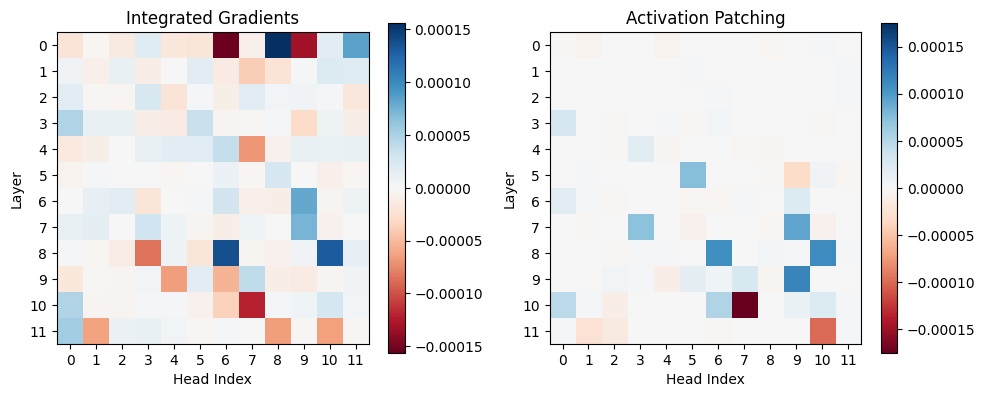

In [39]:
plot_attn_comparison(ig_attn_results, ap_attn_results, model)

In [47]:
import seaborn as sns
import numpy as np

def plot_correlation(x, y, x_label: str, y_label: str, title: str):
    assert x.size(0) == y.size(0)
    n_results = x.size(0)

    for i in range(n_results):
        xi = x[i].flatten().numpy()
        yi = y[i].flatten().numpy()
        sns.regplot(x=xi, y=yi)
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.title(f"{title}")

        plt.tight_layout()
        plt.show()

        print(f"Correlation coefficient: {np.corrcoef(xi, yi)[0, 1]}")

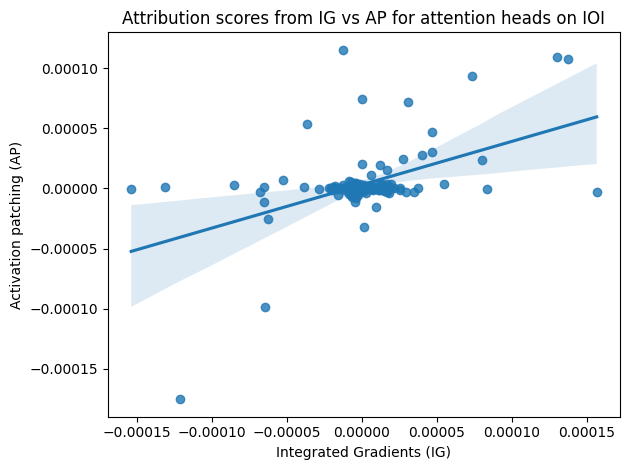

Correlation coefficient: 0.4884673573982641


In [48]:
plot_correlation(ig_attn_results, ap_attn_results, "Integrated Gradients (IG)", "Activation patching (AP)", "Attribution scores from IG vs AP for attention heads on IOI")

### General results

In [49]:
ig_attn_results = torch.load("results/initial/ig_attn_zero_results.pt")
ig_mlp_results = torch.load("results/initial/ig_mlp_zero_results.pt")

# Same runs as in experiment 4 with latent components, patching from corrupt to clean
ap_mlp_results = torch.load("results/latent_components/ioi/ap_clean_corrupt_mlp.pt")
ap_attn_results = torch.load("results/latent_components/ioi/ap_clean_corrupt_attn.pt")


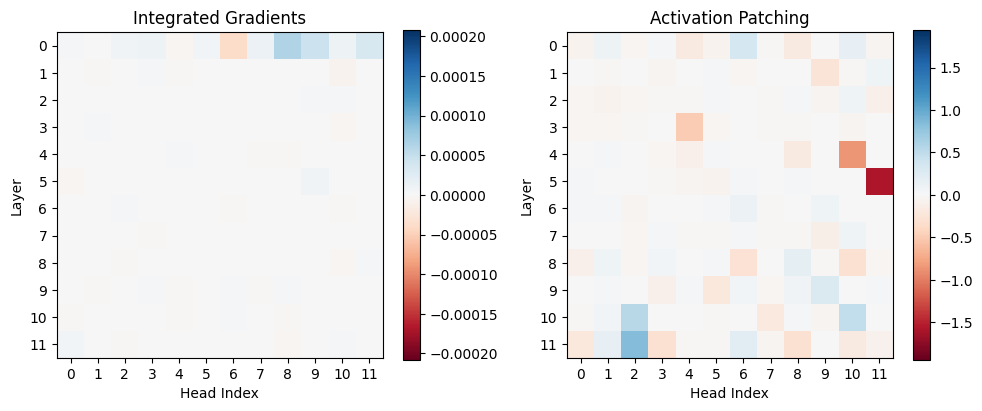

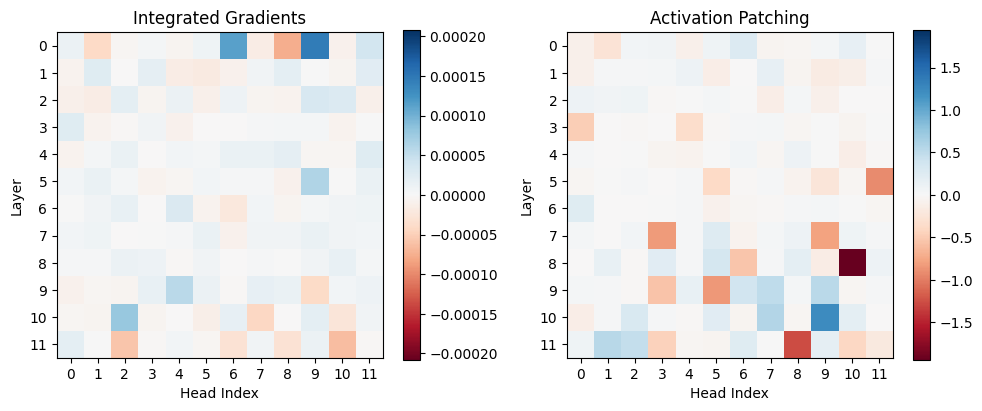

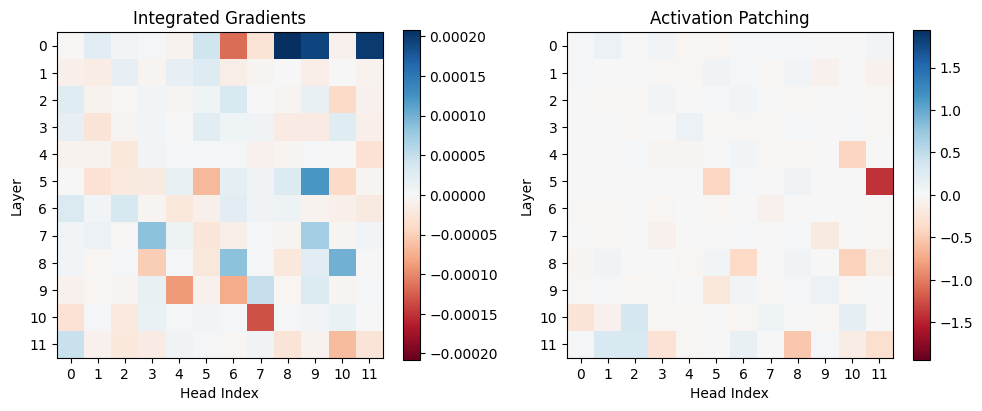

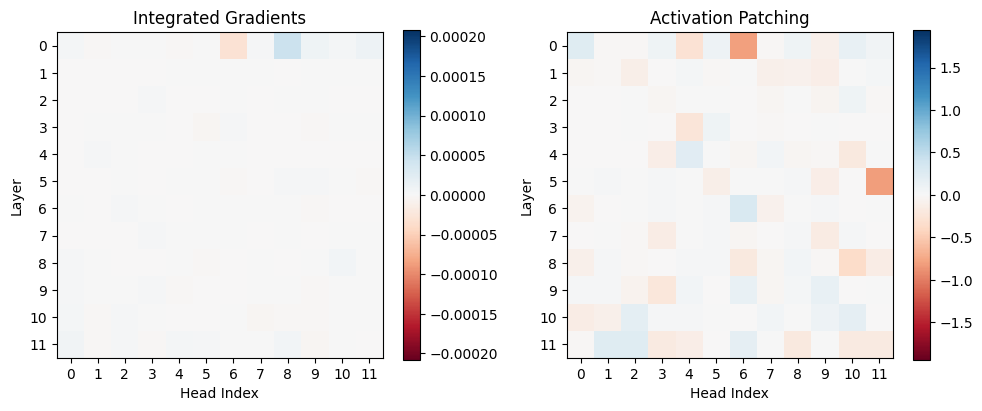

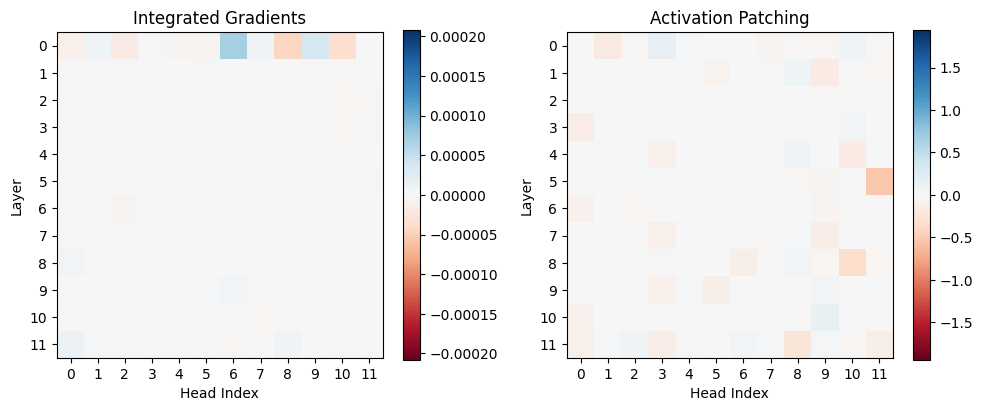

In [52]:
plot_attn_comparison(ig_attn_results[10:15], ap_attn_results[:5], model)

In [61]:
# Mean and standard deviation
print(f"Mean attribution score for IG attention heads: {torch.mean(torch.mean(ig_attn_results, dim=(1,2)))}")
print(f"Standard deviation of attribution score for IG attention heads: {torch.mean(torch.std(ig_attn_results, dim=(1,2)))}")

print(f"Mean attribution score for IG MLP neurons: {torch.mean(torch.mean(ig_mlp_results, dim=(1,2)))}")
print(f"Standard deviation of attribution score for IG MLP neurons: {torch.mean(torch.std(ig_mlp_results, dim=(1,2)))}")

print(f"Mean attribution score for AP attention heads: {torch.mean(torch.mean(ap_attn_results, dim=(1,2)))}")
print(f"Standard deviation of attribution score for AP attention heads: {torch.mean(torch.std(ap_attn_results, dim=(1,2)))}")

print(f"Mean attribution score for AP MLP neurons: {torch.mean(torch.mean(ap_mlp_results, dim=(1,2)))}")
print(f"Standard deviation of attribution score for AP MLP neurons: {torch.mean(torch.std(ap_mlp_results, dim=(1,2)))}")

Mean attribution score for IG attention heads: 8.965441793407081e-07
Standard deviation of attribution score for IG attention heads: 1.5100118616828695e-05
Mean attribution score for IG MLP neurons: 5.609561412711628e-06
Standard deviation of attribution score for IG MLP neurons: 0.0006846731412224472
Mean attribution score for AP attention heads: -0.019641924649477005
Standard deviation of attribution score for AP attention heads: 0.23508165776729584
Mean attribution score for AP MLP neurons: 1.812431582948193e-05
Standard deviation of attribution score for AP MLP neurons: 0.008947634138166904


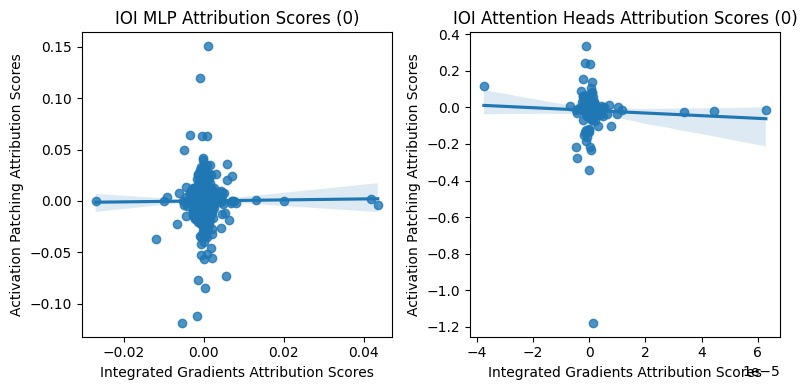

Correlation coefficient for neurons: 0.006726256314604633
Correlation coefficient for attention heads: -0.04629828697393639


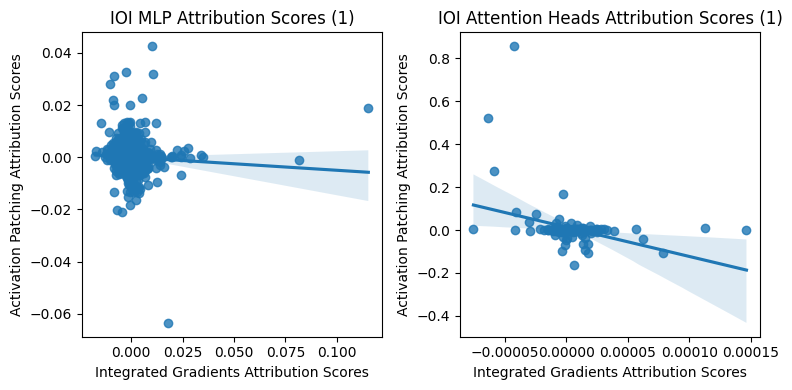

Correlation coefficient for neurons: -0.0644669764292187
Correlation coefficient for attention heads: -0.35865090048645687


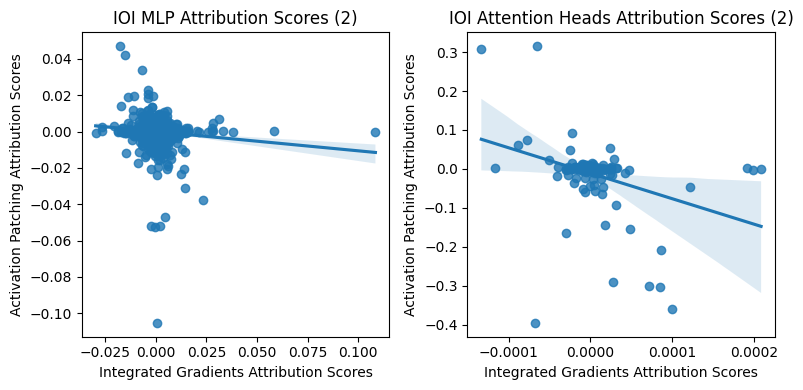

Correlation coefficient for neurons: -0.12435887688408141
Correlation coefficient for attention heads: -0.34892572412355705


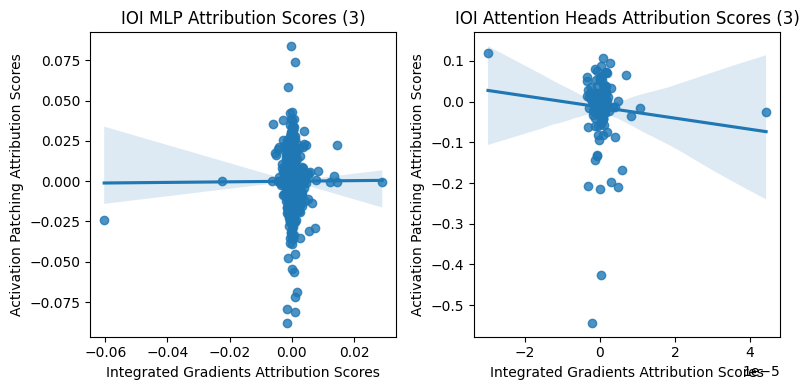

Correlation coefficient for neurons: 0.0025366782055936806
Correlation coefficient for attention heads: -0.08420871937765162


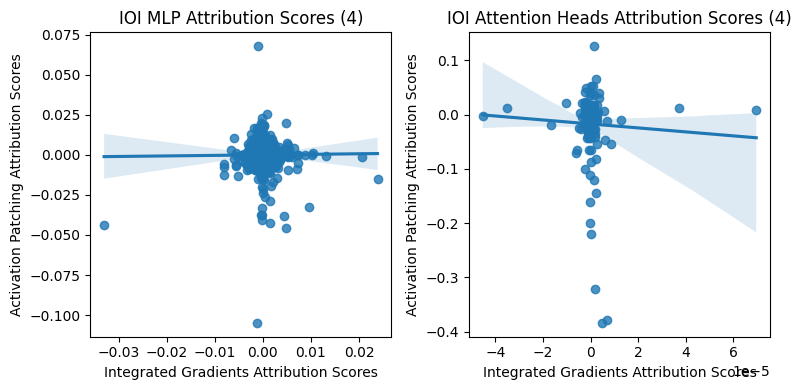

Correlation coefficient for neurons: 0.008449411915094438
Correlation coefficient for attention heads: -0.04791432776082704
Average correlation between MLP neuron scores: -0.02872625021654247
Standard deviation of correlation between MLP neuron scores: 0.07142099822721198
Average correlation between attention head scores: -0.05580745759367625
Standard deviation of correlation between attention head scores: 0.17030660097968173


In [65]:
plot_correlation_comparison(ig_mlp_results[10:15], ap_mlp_results[10:15], ig_attn_results[10:15], ap_attn_results[10:15], Task.IOI)

mlp_corr_avg, mlp_corr_std = average_correlation(ig_mlp_results, ap_mlp_results)
print(f"Average correlation between MLP neuron scores: {mlp_corr_avg}")
print(f"Standard deviation of correlation between MLP neuron scores: {mlp_corr_std}")

attn_corr_avg, attn_corr_std = average_correlation(ig_attn_results, ap_attn_results)
print(f"Average correlation between attention head scores: {attn_corr_avg}")
print(f"Standard deviation of correlation between attention head scores: {attn_corr_std}")

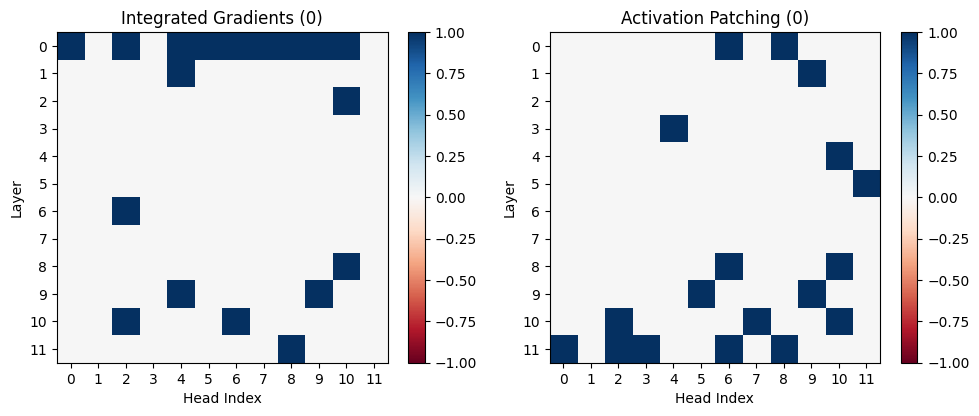

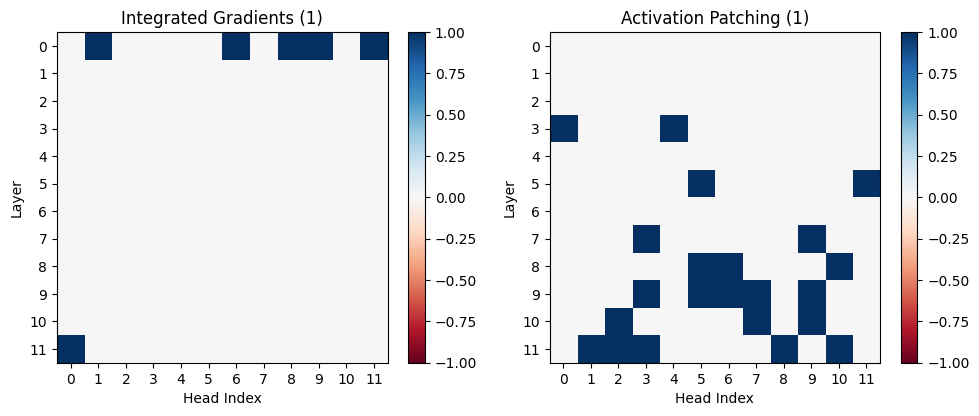

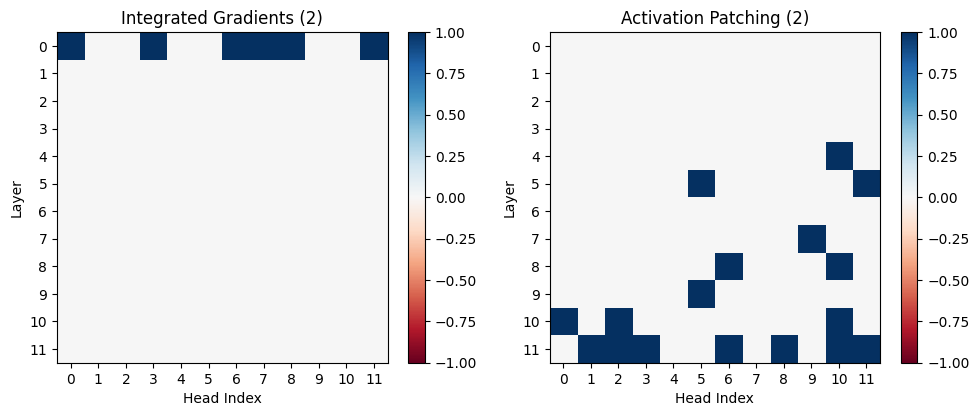

Average overlap between IG and AP highlighted attention heads: 0.10214278846979141


In [8]:
ig_attn_significant, _ = highlight_components(ig_attn_results)
ap_attn_significant, _ = highlight_components(ap_attn_results)

plot_attn_comparison(ig_attn_significant[:3].int(), ap_attn_significant[:3].int(), model)

attn_overlap = measure_overlap(ig_attn_significant, ap_attn_significant)
print(f"Average overlap between IG and AP highlighted attention heads: {attn_overlap.mean()}")

In [9]:
ig_mlp_significant, _ = highlight_components(ig_mlp_results)
ap_mlp_significant, _ = highlight_components(ap_mlp_results)

mlp_overlap = measure_overlap(ig_mlp_significant, ap_mlp_significant)
print(f"Average overlap between IG and AP highlighted MLP neurons: {mlp_overlap.mean()}")

Average overlap between IG and AP highlighted MLP neurons: 0.1215241551399231


/vol/bitbucket/mwl21/fypvenv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


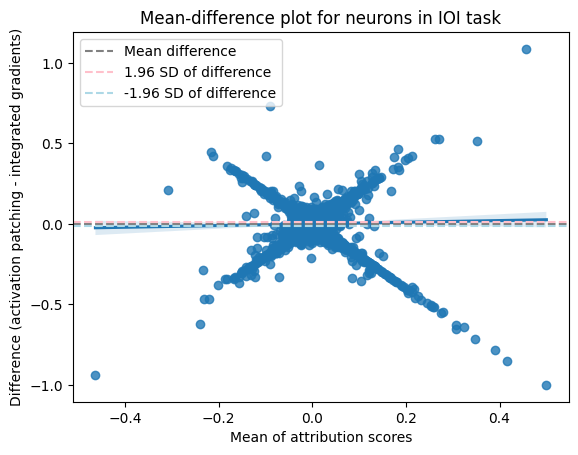

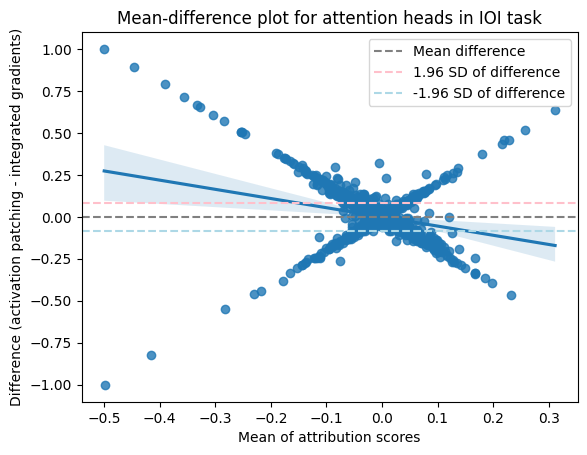

In [10]:
plot_mean_diff(ig_mlp_results, ap_mlp_results, "Mean-difference plot for neurons in IOI task")
plot_mean_diff(ig_attn_results, ap_attn_results, "Mean-difference plot for attention heads in IOI task")